In [1]:
import os
import requests
import pandas as pd
import matplotlib.pyplot as plt
import math
import tiktoken
import torch
import torch.nn as nn

In [2]:
# Hyperparameters
batch_size = 4  # How many batches per training step
context_length = 16  # Length of the token chunk each batch
d_model = 64  # The vector size of the token embeddings
num_layers = 8  # Number of transformer blocks
num_heads = 4  # Number of heads in Multi-head attention # 我们的代码中通过 d_model / num_heads = 来获取 head_size
learning_rate = 1e-3  # 0.001
dropout = 0.1 # Dropout rate
max_iters = 500  # Total of training iterations
eval_interval = 50  # How often to evaluate the model 
eval_iters = 20  # How many iterations to average the loss over when evaluating the model
device = 'cuda' if torch.cuda.is_available() else 'cpu'  # Instead of using the cpu, we'll use the GPU if it's available.

TORCH_SEED = 1337
torch.manual_seed(TORCH_SEED)

In [3]:
# download a sample txt file from https://huggingface.co/datasets/goendalf666/sales-textbook_for_convincing_and_selling/raw/main/sales_textbook.txt
if not os.path.exists('data/sales_textbook.txt'):
    url = 'https://huggingface.co/datasets/goendalf666/sales-textbook_for_convincing_and_selling/raw/main/sales_textbook.txt'
    with open('sales_textbook.txt', 'w') as f:
        f.write(requests.get(url).text)

with open('data/sales_textbook.txt', 'r', encoding='utf-8') as f:
    text = f.read()
print(text[1])

h


In [4]:
def compare_encodings(example_string: str) -> None:
    """Prints a comparison of three string encodings."""
    # print the example string
    print(f'\nExample string: "{example_string}"')
    # for each encoding, print the # of tokens, the token integers, and the token bytes
    for encoding_name in ["gpt2", "p50k_base", "cl100k_base"]:
        encoding = tiktoken.get_encoding(encoding_name)
        token_integers = encoding.encode(example_string)
        num_tokens = len(token_integers)
        token_bytes = [encoding.decode_single_token_bytes(token) for token in token_integers]
        print()
        print(f"{encoding_name}: {num_tokens} tokens")
        print(f"token integers: {token_integers}")
        print(f"token bytes: {token_bytes}")

compare_encodings("hello, I'm your old brother! you don't know who I am")
compare_encodings("2 + 2 = 4")
compare_encodings("お誕生日おめでとう")


Example string: "hello, I'm your old brother! you don't know who I am"

gpt2: 15 tokens
token integers: [31373, 11, 314, 1101, 534, 1468, 3956, 0, 345, 836, 470, 760, 508, 314, 716]
token bytes: [b'hello', b',', b' I', b"'m", b' your', b' old', b' brother', b'!', b' you', b' don', b"'t", b' know', b' who', b' I', b' am']

p50k_base: 15 tokens
token integers: [31373, 11, 314, 1101, 534, 1468, 3956, 0, 345, 836, 470, 760, 508, 314, 716]
token bytes: [b'hello', b',', b' I', b"'m", b' your', b' old', b' brother', b'!', b' you', b' don', b"'t", b' know', b' who', b' I', b' am']

cl100k_base: 15 tokens
token integers: [15339, 11, 358, 2846, 701, 2362, 10868, 0, 499, 1541, 956, 1440, 889, 358, 1097]
token bytes: [b'hello', b',', b' I', b"'m", b' your', b' old', b' brother', b'!', b' you', b' don', b"'t", b' know', b' who', b' I', b' am']

Example string: "2 + 2 = 4"

gpt2: 5 tokens
token integers: [17, 1343, 362, 796, 604]
token bytes: [b'2', b' +', b' 2', b' =', b' 4']

p50k_base: 5 tokens


In [5]:
# Using TikToken to tokenize the source text
encoding = tiktoken.get_encoding("cl100k_base")
tokenized_text = encoding.encode(text)
tokenized_text = torch.tensor(tokenized_text, dtype=torch.long, device=device) # Convert tokens into a tensor
max_token_value = tokenized_text.max().item() # the maximum index value in our vocabulary

print(f"Tokenized text size: {len(tokenized_text)}")
print(f"The maximum value in the tokenized text is: {max_token_value}")

Tokenized text size: 77919
The maximum value in the tokenized text is: 100069


In [7]:
print(tokenized_text.max())

tensor(100069, device='cuda:0')


## OpenAI官方分词工具
https://platform.openai.com/tokenizer  

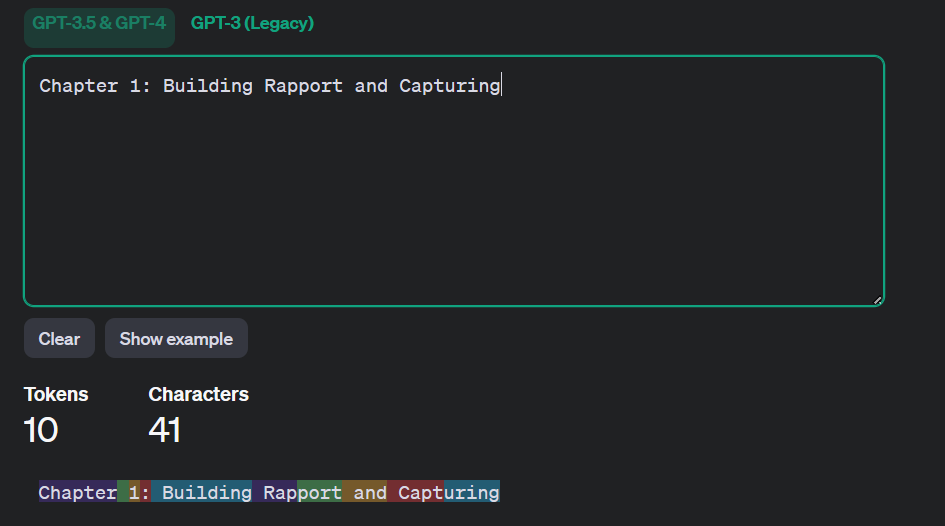

In [11]:
# Illustration purpose
text = 'Chapter 1: Building Rapport and Capturing'
encoding_integar = encoding.encode(text)
print(encoding_integar)
# for i in encoding_integar:
#     token_bytes = encoding.decode_single_token_bytes(i)
#     print(token_bytes)
print(encoding.decode(encoding_integar))

[26072, 220, 16, 25, 17283, 23097, 403, 323, 17013, 1711]
Chapter 1: Building Rapport and Capturing


In [12]:
# Split train and validation
split_idx = int(len(tokenized_text) * 0.9)
train_data = tokenized_text[:split_idx]
val_data = tokenized_text[split_idx:]

In [19]:
# Prepare data for training batch
data = train_data
idxs = torch.randint(low=0, high=len(data) - context_length, size=(batch_size,))
print(idxs)
x_batch = torch.stack([data[idx:idx + context_length] for idx in idxs])
y_batch = torch.stack([data[idx + 1:idx + context_length + 1] for idx in idxs])
print(x_batch.shape, x_batch.shape)
print(x_batch.data)

tensor([61650, 29290, 45238, 54043])
torch.Size([4, 16]) torch.Size([4, 16])
tensor([[  907,   323,  7720,   315,   279, 10209,  7612,   264, 16195,  8830,
           315,   279,  3230,  4519,    11, 22934],
        [ 3619,   872,  6671,   323,   527, 10235,   311,  2686,   872, 10742,
         13750,   627,  1271,  9788,  6130,  3966],
        [ 4954,   279, 15864,   311,  5398,   449,   872, 19882,    11,  6763,
         16455,   649,  5813, 39474,   323,  4667],
        [  433,  8831,   311,  2686, 54111, 13750,   627,    18,    13,  5075,
         45252, 14847,    25,  9843,   499,   617]], device='cuda:0')


In [30]:
data[61650]

tensor(907, device='cuda:0')

In [29]:
# Illustration purpose
pd.set_option('display.expand_frame_repr', False)
print("Our batches:\n", pd.DataFrame(x_batch.detach().cpu().numpy()))

Our batches:
      0     1      2     3      4      5     6      7      8      9      10     11    12     13    14     15
0   907   323   7720   315    279  10209  7612    264  16195   8830    315    279  3230   4519    11  22934
1  3619   872   6671   323    527  10235   311   2686    872  10742  13750    627  1271   9788  6130   3966
2  4954   279  15864   311   5398    449   872  19882     11   6763  16455    649  5813  39474   323   4667
3   433  8831    311  2686  54111  13750   627     18     13   5075  45252  14847    25   9843   499    617


In [43]:
# Define Token Embedding look-up table
token_embedding_lookup_table = nn.Embedding(max_token_value+1, d_model).to(device) #gpt3 使用的是50257 * 2400 = 120616800 = 1.2亿
print("Token Embedding Look-up table: ", token_embedding_lookup_table)

Token Embedding Look-up table:  Embedding(100070, 64)


In [46]:
_ = token_embedding_lookup_table(data[61650]) # 
pd.set_option('expand_frame_repr', True)
pd.DataFrame(_.detach().cpu().numpy())

,0
0,-2.212647
1,0.297753
2,-3.055725
3,0.806543
4,-0.694040
...,...
59,-1.859645
60,-0.086165
61,-0.847091
62,1.117803


In [53]:
# Get x and y embedding
x_batch_embedding = token_embedding_lookup_table(x_batch.detach().to(device)) # [4, 16, 64] [batch_size, context_length, d_model]
y_batch_embedding = token_embedding_lookup_table(y_batch.detach().to(device))

x_batch_embedding.shape, y_batch_embedding.shape
pd.DataFrame(x_batch_embedding[0].detach().cpu().numpy())


,0,1,2,3,4,5,6,7,8,9,...,54,55,56,57,58,59,60,61,62,63
0,-2.212647,0.297753,-3.055725,0.806543,-0.694040,-1.220876,-0.553348,-1.068499,1.874142,-1.802700,...,-0.703924,0.252192,0.441080,0.781842,-0.817928,-1.859645,-0.086165,-0.847091,1.117803,-0.029158
1,0.163428,0.356100,-0.201130,1.228454,-0.195298,-0.638541,0.412331,-1.323215,1.024879,-0.156247,...,0.217936,-0.464949,0.423034,1.351880,-0.935294,-0.860999,-1.524410,-0.530229,-1.977449,-0.185218
2,0.622345,0.902375,1.074955,-0.153993,0.275876,0.573445,-1.836374,-0.327863,-0.380139,-0.059371,...,-1.446814,-0.137588,-0.546827,0.581914,0.398899,0.209200,-0.048184,-0.642811,1.373216,-0.418497
3,-0.732512,0.782530,2.451140,-1.384321,-1.534551,0.247991,-0.213578,1.727196,0.578335,-1.785926,...,0.769649,-0.092221,-0.030181,1.320257,-0.721869,0.292648,0.093519,1.221405,-0.294572,0.550066
4,-0.010836,-2.327541,1.814761,1.187953,1.051353,-0.898724,-1.719734,-1.044743,-0.389149,-0.635654,...,-1.554788,-2.298720,-0.710414,-0.294389,-1.025667,0.218043,-1.195265,-0.458907,-0.438904,1.758305
5,0.284641,1.317682,-0.241485,0.102594,-2.025578,-0.088731,-1.665121,0.481327,0.586246,-1.595611,...,0.259089,0.619045,-2.511999,-0.300577,-0.442211,-1.318571,-0.012520,-0.870035,0.449365,-1.220784
6,0.264409,-1.320855,-1.017277,-0.117703,-1.011276,-0.568748,0.128305,0.115567,-0.857696,-1.633143,...,-0.731540,-1.163984,-0.425715,-0.422265,-0.158232,0.986544,1.275417,1.773719,-0.404207,-2.051980
7,-0.384749,-0.409432,1.078871,1.318739,-0.792736,-1.373335,0.997960,1.179791,0.192261,0.063750,...,-1.528252,-0.888050,0.589744,0.092824,-0.549972,0.135838,0.565290,0.505337,0.940611,-0.443011
8,0.009831,-0.501210,-1.078422,1.250769,-0.209081,0.608596,0.504215,0.253966,-0.410589,-0.262492,...,-0.834482,-0.186426,-2.079033,-0.389441,1.323192,1.811475,1.301881,1.334729,0.088032,0.842523
9,0.048790,-0.406126,1.471536,2.192314,1.200676,-0.389114,-0.245289,0.028587,-0.988648,2.693502,...,1.884973,1.043723,-0.762297,0.100989,0.035869,0.643947,0.219704,0.590646,-0.669782,-0.910646


### 位置编码 Position Encoding PE

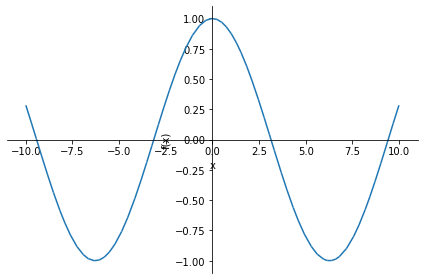

In [67]:
import sympy
x = sympy.symbols('x')
sinx = sympy.cos(0.5*x)
sympy.plot(sinx)

In [59]:
# Define Position Encoding look-up table
position_encoding_lookup_table = torch.zeros(context_length, d_model)
position = torch.arange(0, context_length, dtype=torch.float).unsqueeze(1)
div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
#div_term_ = 1/(10000 ** (torch.arange(0, d_model, 2).float()/d_model))
position_encoding_lookup_table[:, 0::2] = torch.sin(position * div_term)
position_encoding_lookup_table[:, 1::2] = torch.cos(position * div_term)
position_encoding_lookup_table = position_encoding_lookup_table.unsqueeze(0).expand(batch_size, -1, -1) #add batch dimension

print("Position Encoding Look-up Table: ", position_encoding_lookup_table.shape) # [4, 16, 64] [batch_size, context_length, d_model]
pd.DataFrame(position_encoding_lookup_table[0].detach().cpu().numpy())


Position Encoding Look-up Table:  torch.Size([4, 16, 64])


,0,1,2,3,4,5,6,7,8,9,...,54,55,56,57,58,59,60,61,62,63
0,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,...,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000
1,0.841471,0.540302,0.681561,0.731761,0.533168,0.846009,0.409309,0.912396,0.310984,0.950415,...,0.000422,1.000000,0.000316,1.000000,0.000237,1.000000,0.000178,1.000000,0.000133,1.000000
2,0.909297,-0.416147,0.997480,0.070948,0.902131,0.431463,0.746903,0.664932,0.591127,0.806578,...,0.000843,1.000000,0.000632,1.000000,0.000474,1.000000,0.000356,1.000000,0.000267,1.000000
3,0.141120,-0.989992,0.778273,-0.627927,0.993253,-0.115966,0.953634,0.300967,0.812649,0.582754,...,0.001265,0.999999,0.000949,1.000000,0.000711,1.000000,0.000533,1.000000,0.000400,1.000000
4,-0.756802,-0.653644,0.141539,-0.989933,0.778472,-0.627680,0.993281,-0.115730,0.953581,0.301137,...,0.001687,0.999999,0.001265,0.999999,0.000949,1.000000,0.000711,1.000000,0.000533,1.000000
5,-0.958924,0.283662,-0.571127,-0.820862,0.323935,-0.946079,0.858896,-0.512150,0.999947,-0.010342,...,0.002108,0.999998,0.001581,0.999999,0.001186,0.999999,0.000889,1.000000,0.000667,1.000000
6,-0.279415,0.960170,-0.977396,-0.211416,-0.230368,-0.973104,0.574026,-0.818837,0.947148,-0.320796,...,0.002530,0.999997,0.001897,0.999998,0.001423,0.999999,0.001067,0.999999,0.000800,1.000000
7,0.656987,0.753902,-0.859313,0.511449,-0.713721,-0.700430,0.188581,-0.982058,0.800422,-0.599437,...,0.002952,0.999996,0.002214,0.999998,0.001660,0.999999,0.001245,0.999999,0.000933,1.000000
8,0.989358,-0.145500,-0.280228,0.959933,-0.977262,-0.212036,-0.229904,-0.973213,0.574318,-0.818632,...,0.003374,0.999994,0.002530,0.999997,0.001897,0.999998,0.001423,0.999999,0.001067,0.999999
9,0.412118,-0.911130,0.449194,0.893434,-0.939824,0.341660,-0.608108,-0.793854,0.291259,-0.956644,...,0.003795,0.999993,0.002846,0.999996,0.002134,0.999998,0.001600,0.999999,0.001200,0.999999


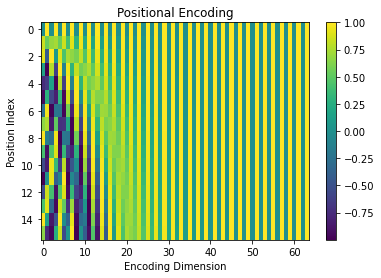

In [15]:
# Illustration Purpose Only
def visualize_pe(pe):
    plt.imshow(pe, aspect="auto")
    plt.title("Positional Encoding")
    plt.xlabel("Encoding Dimension")
    plt.ylabel("Position Index")
    plt.colorbar()
    plt.show()

position_encoding_lookup_table2_np = position_encoding_lookup_table[0].cpu().numpy()
visualize_pe(position_encoding_lookup_table2_np)

In [69]:
# Add positional encoding into the input embedding vector
input_embedding_x = x_batch_embedding + position_encoding_lookup_table.to(device) # [4, 16, 64] [batch_size, context_length, d_model]
input_embedding_y = y_batch_embedding + position_encoding_lookup_table.to(device)
pd.DataFrame(input_embedding_x[0].detach().cpu().numpy())

,0,1,2,3,4,5,6,7,8,9,...,54,55,56,57,58,59,60,61,62,63
0,-2.212647,1.297753,-3.055725,1.806543,-0.694040,-0.220876,-0.553348,-0.068499,1.874142,-0.802700,...,-0.703924,1.252192,0.441080,1.781842,-0.817928,-0.859645,-0.086165,0.152909,1.117803,0.970842
1,1.004899,0.896403,0.480432,1.960215,0.337870,0.207468,0.821640,-0.410819,1.335863,0.794169,...,0.218358,0.535051,0.423350,2.351880,-0.935056,0.139001,-1.524232,0.469771,-1.977316,0.814782
2,1.531642,0.486228,2.072435,-0.083045,1.178007,1.004908,-1.089470,0.337069,0.210988,0.747207,...,-1.445970,0.862411,-0.546194,1.581914,0.399373,1.209200,-0.047828,0.357189,1.373483,0.581503
3,-0.591392,-0.207463,3.229412,-2.012248,-0.541298,0.132024,0.740057,2.028163,1.390984,-1.203172,...,0.770914,0.907778,-0.029232,2.320257,-0.721158,1.292648,0.094053,2.221405,-0.294172,1.550066
4,-0.767639,-2.981185,1.956300,0.198020,1.829825,-1.526404,-0.726453,-1.160473,0.564431,-0.334516,...,-1.553101,-1.298722,-0.709149,0.705610,-1.024718,1.218043,-1.194553,0.541093,-0.438370,2.758305
5,-0.674284,1.601344,-0.812612,-0.718268,-1.701642,-1.034811,-0.806225,-0.030823,1.586192,-1.605954,...,0.261198,1.619043,-2.510417,0.699422,-0.441025,-0.318571,-0.011631,0.129964,0.450032,-0.220784
6,-0.015006,-0.360685,-1.994673,-0.329119,-1.241644,-1.541852,0.702331,-0.703271,0.089452,-1.953939,...,-0.729010,-0.163987,-0.423817,0.577733,-0.156809,1.986543,1.276484,2.773719,-0.403406,-1.051980
7,0.272237,0.344471,0.219557,1.830189,-1.506458,-2.073765,1.186541,0.197734,0.992683,-0.535687,...,-1.525300,0.111945,0.591957,1.092822,-0.548312,1.135836,0.566534,1.505336,0.941544,0.556988
8,0.999189,-0.646710,-1.358650,2.210703,-1.186343,0.396560,0.274311,-0.719247,0.163729,-1.081125,...,-0.831108,0.813568,-2.076503,0.610556,1.325089,2.811474,1.303303,2.334728,0.089098,1.842523
9,0.460909,-1.317256,1.920729,3.085748,0.260852,-0.047454,-0.853397,-0.765267,-0.697389,1.736858,...,1.888768,2.043715,-0.759451,1.100985,0.038003,1.643944,0.221304,1.590645,-0.668582,0.089353


In [71]:
# Prepare Query, Key, Value for Multi-head Attention
X = input_embedding_x
query = key = value = X # [4, 16, 64] [batch_size, context_length, d_model]
query.shape

torch.Size([4, 16, 64])

In [77]:
# Define Query, Key, Value weight matrices #12228*12228*3 96个head 96层
Wq = nn.Linear(d_model, d_model).to(device)
Wk = nn.Linear(d_model, d_model).to(device)
Wv = nn.Linear(d_model, d_model).to(device)

Q = Wq(query).to(device) #[4, 16, 64]
Q = Q.view(batch_size, -1, num_heads, d_model // num_heads)  #[4, 16, 4, 16]

K = Wk(key).to(device) #[4, 16, 64]
K = K.view(batch_size, -1, num_heads, d_model // num_heads)  #[4, 16, 4, 16]

V = Wv(value).to(device)#[4, 16, 64]
V = V.view(batch_size, -1, num_heads, d_model // num_heads)  #[4, 16, 4, 16]

# print(torch.round(Q[0] * 100) / 100)
qqq = Q.detach().cpu().numpy()
pd.set_option('expand_frame_repr', False)
for qs in qqq:
    for qss in qs:
        print(pd.DataFrame(qss))

print(Q.shape) # [4, 16, 4, 16] [batch_size, context_length, num_heads, head_size]

         0         1         2         3         4         5         6         7         8         9         10        11        12        13        14        15
0  0.413911 -0.432314 -0.354050  1.498257  0.331163  0.632072 -0.106911 -0.457786 -0.680657  1.491352 -0.309656 -0.789586 -0.440848  0.839570  0.194878 -0.318608
1 -0.368366 -0.889032  0.951598 -1.310171  0.460029  0.984568 -0.926807  0.091594 -0.441113  0.837245  0.723781 -0.094497  0.565916 -0.428840 -1.287644  0.192532
2  0.465366  0.084294  0.046073 -0.929983  0.578798  0.606870  1.323131 -0.238044 -1.062850 -0.451752  0.939982 -1.232529  0.039188 -0.569816 -0.473610  1.694597
3 -0.050627  0.516611  0.317686  0.049416 -0.871029 -0.062722  0.785501  0.457837  0.689017  1.044204 -0.015390 -0.360337 -1.232019  1.255368  0.996269 -1.740878
         0         1         2         3         4         5         6         7         8         9         10        11        12        13        14        15
0 -0.264244 -1.323658 -0.514

In [78]:
# Transpose q,k,v from [batch_size, context_length, num_heads, head_size] to [batch_size, num_heads, context_length, head_size]
# The reason is that treat each batch with "num_heads" as its first dimension.
Q = Q.transpose(1, 2) # [4, 4, 16, 16]
K = K.transpose(1, 2) # [4, 4, 16, 16]
V = V.transpose(1, 2) # [4, 4, 16, 16]

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0,0.942747,0.301987,0.076769,0.357016,0.088803,-0.075620,-0.435334,0.187326,-0.040142,0.357808,0.222629,0.022910,0.012627,0.215433,0.633460,0.140513
1,0.666726,0.590242,-0.588499,-0.353099,-0.152888,-0.376779,-0.865644,-0.621432,-0.022253,0.360274,-0.135069,0.205063,0.295692,0.131793,1.138780,0.638101
2,-0.016824,0.129671,-0.103896,0.314878,0.544786,-0.504721,-0.417172,-0.576782,0.404575,-0.494371,0.347147,0.613070,-1.067897,-0.451031,0.550679,0.396056
3,0.727953,0.281151,-0.119108,0.784263,0.188638,-0.377546,-0.411456,-0.022531,0.095267,0.400618,0.769561,0.257648,-0.432845,-0.973785,0.545442,-0.508007
4,0.099835,0.550877,0.620517,0.870620,0.522018,-0.377896,-0.191000,-0.059321,0.255104,0.098930,0.659649,0.432951,-0.763889,-0.071100,0.623037,0.535148
5,0.096971,0.268650,-0.015535,0.000167,0.288388,-0.503231,-0.448586,-0.438755,0.440614,-0.672576,-0.012022,0.225043,-0.824661,-0.036944,0.046671,0.605919
6,0.624417,-0.158881,0.135464,0.270206,1.071724,0.153830,0.702825,0.970270,0.542127,0.740764,0.286086,0.957539,-0.062430,-0.184733,0.090897,-0.350447
7,0.006409,0.395152,0.552841,0.404704,0.438683,-0.439001,-0.062454,0.279047,0.014946,0.182441,0.374164,0.500280,0.237008,0.248373,0.830630,0.462579
8,-0.157531,0.257012,-0.061052,-0.286183,-0.014002,-0.693578,-0.923258,-0.319093,-0.182178,-0.445925,-0.099896,0.267521,0.443713,-0.014089,0.077261,0.010580
9,0.195955,0.173675,0.169200,0.714135,0.498230,-0.405213,-0.455564,-0.145160,0.193628,0.088084,0.644521,0.532141,-0.320644,-0.190354,0.601006,0.617722


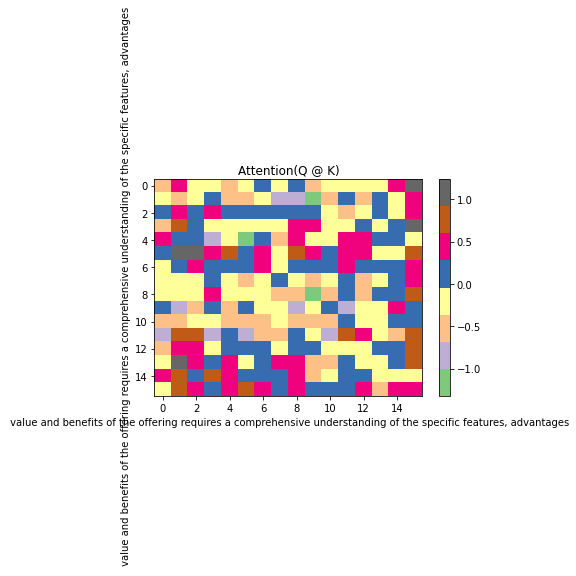

In [79]:
# Calculate the attention score
attention_score = torch.matmul(Q, K.transpose(-2, -1)) / math.sqrt(d_model // num_heads) # [4, 4, 16, 16]

# Illustration only
plt.imshow(attention_score[1, 1].detach().cpu().numpy(), "Accent", aspect="auto")
plt.title("Attention(Q @ K)") #plot attention in the first head of the first batch
plt.xlabel(encoding.decode(x_batch[0].tolist()))
plt.ylabel(encoding.decode(x_batch[0].tolist()))
plt.colorbar()
pd.DataFrame(attention_score[0][0].detach().cpu().numpy())

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0,0.942747,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf
1,0.666726,0.590242,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf
2,-0.016824,0.129671,-0.103896,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf
3,0.727953,0.281151,-0.119108,0.784263,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf
4,0.099835,0.550877,0.620517,0.870620,0.522018,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf
5,0.096971,0.268650,-0.015535,0.000167,0.288388,-0.503231,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf
6,0.624417,-0.158881,0.135464,0.270206,1.071724,0.153830,0.702825,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf
7,0.006409,0.395152,0.552841,0.404704,0.438683,-0.439001,-0.062454,0.279047,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf
8,-0.157531,0.257012,-0.061052,-0.286183,-0.014002,-0.693578,-0.923258,-0.319093,-0.182178,-inf,-inf,-inf,-inf,-inf,-inf,-inf
9,0.195955,0.173675,0.169200,0.714135,0.498230,-0.405213,-0.455564,-0.145160,0.193628,0.088084,-inf,-inf,-inf,-inf,-inf,-inf


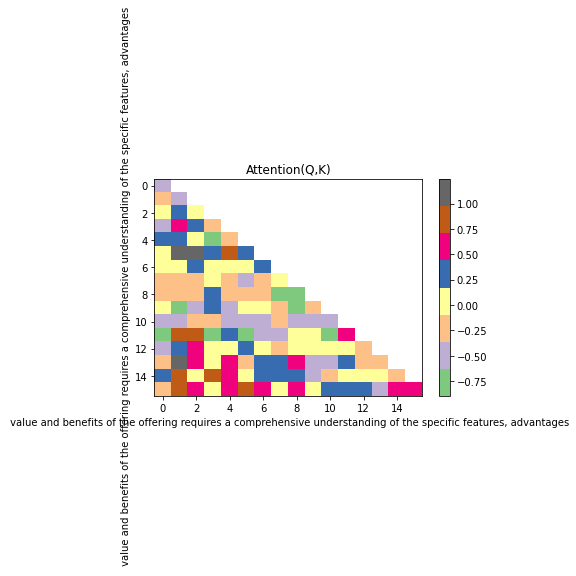

In [83]:
# Apply Mask to attention scores
attention_score = attention_score.masked_fill(torch.triu(torch.ones(attention_score.shape[-2:]).to(device), diagonal=1).bool(), float('-inf'))#[4, 4, 16, 16] [batch_size, num_heads, context_length, context_length]

# Illustration only
plt.imshow(attention_score[1, 1].detach().cpu().numpy(), "Accent", aspect="auto")
plt.title("Attention(Q,K)")
plt.xlabel(encoding.decode(x_batch[0].tolist()))
plt.ylabel(encoding.decode(x_batch[0].tolist()))
plt.colorbar()
pd.DataFrame(attention_score[0][0].detach().cpu().numpy())

In [84]:
# Softmax the attention score
attention_score = torch.softmax(attention_score, dim=-1) #[4, 4, 16, 16] [batch_size, num_heads, context_length, context_length]
pd.DataFrame(attention_score[0][0].detach().cpu().numpy())

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.519112,0.480888,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,0.325269,0.376586,0.298145,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,0.319870,0.204611,0.137120,0.338399,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,0.125947,0.197730,0.211990,0.272229,0.192105,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
5,0.173965,0.206548,0.155454,0.157914,0.210665,0.095455,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
6,0.165503,0.075618,0.101498,0.116138,0.258862,0.103379,0.179002,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
7,0.098817,0.145768,0.170665,0.147167,0.152253,0.063299,0.092241,0.129789,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
8,0.117301,0.177555,0.129182,0.103140,0.135405,0.068627,0.054544,0.099801,0.114445,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
9,0.103527,0.101246,0.100794,0.173819,0.140065,0.056751,0.053964,0.073606,0.103287,0.092941,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [85]:
# Calculate the V attention output
print(attention_score.shape) #[4, 4, 16, 16] [batch_size, num_heads, context_length, context_length]
print(V.shape) #[4, 4, 16, 16] [batch_size, num_heads, context_length, head_size]
A = torch.matmul(attention_score, V) # [4, 4, 16, 16] [batch_size, num_heads, context_length, head_size]
print(A.shape)

torch.Size([4, 4, 16, 16])
torch.Size([4, 4, 16, 16])
torch.Size([4, 4, 16, 16])


In [86]:
# Concatenate the attention output
A = A.transpose(1, 2) # [4, 16, 4, 16] [batch_size, context_length, num_heads, head_size]
A = A.reshape(batch_size, -1, d_model) # [4, 16, 64] [batch_size, context_length, d_model]
A.shape

torch.Size([4, 16, 64])

In [88]:
# Define the output weight matrix  
Wo = nn.Linear(d_model, d_model).to(device)
output = Wo(A) # [4, 16, 64] [batch_size, context_length, d_model]
print(output.shape)
pd.DataFrame(output[0].detach().cpu().numpy())

torch.Size([4, 16, 64])


,0,1,2,3,4,5,6,7,8,9,...,54,55,56,57,58,59,60,61,62,63
0,0.217016,-0.084742,0.135017,-0.244709,0.000267,0.052206,-0.403072,-0.177751,0.189971,-0.335659,...,-0.689762,0.036375,-0.546142,-0.325927,-0.652442,-0.099255,1.006100,-0.170647,-0.458756,0.685856
1,-0.014204,0.007856,0.449970,-0.183704,0.117348,0.424739,-0.040474,-0.437166,-0.303344,-0.191225,...,-0.643533,-0.138316,-0.245559,-0.264239,-0.227470,-0.099347,0.923428,-0.145727,-0.320921,0.385725
2,0.019643,0.179037,0.452983,-0.134549,0.013718,0.316029,-0.036011,-0.537750,-0.230358,-0.249379,...,-0.625180,-0.265652,-0.135304,-0.292224,-0.100959,-0.175635,0.792728,-0.207391,-0.153791,0.483166
3,-0.012626,0.183284,0.330691,-0.161986,-0.258927,0.325882,-0.082581,-0.377961,0.030390,-0.240397,...,-0.618272,-0.154178,-0.278331,-0.455783,-0.322355,-0.225979,0.666613,-0.318927,-0.201652,0.424324
4,-0.007003,0.024983,0.497118,-0.094114,-0.014453,0.439430,0.161494,-0.409057,-0.359311,-0.291362,...,-0.481018,-0.276340,-0.149641,-0.318481,-0.216158,-0.207018,0.590208,-0.093836,-0.100525,0.503712
5,0.049260,0.168196,0.472927,-0.016483,-0.044058,0.453200,0.112382,-0.525736,-0.452219,-0.168529,...,-0.314086,-0.188003,-0.100332,-0.136314,-0.285772,-0.231868,0.471303,-0.061962,0.014329,0.449963
6,0.029410,0.122121,0.445532,-0.106266,-0.389482,0.347624,-0.001219,-0.427150,-0.255703,-0.234435,...,-0.400509,0.001975,0.003193,-0.045210,-0.227008,-0.272350,0.344958,-0.147570,0.021608,0.310252
7,-0.062457,0.073995,0.562828,-0.083563,-0.313824,0.265149,0.069197,-0.289367,-0.296340,-0.297738,...,-0.513482,-0.162489,0.021681,-0.080604,-0.133677,-0.320884,0.322981,-0.264813,-0.053330,0.303045
8,-0.061925,-0.067144,0.552656,-0.182246,-0.380006,0.312812,0.039628,-0.203110,-0.319137,-0.246367,...,-0.465008,-0.057121,0.081486,-0.024926,-0.169069,-0.291227,0.360913,-0.249238,-0.010103,0.355879
9,-0.087743,-0.045892,0.434540,-0.210696,-0.304989,0.185267,0.098944,-0.147714,-0.173429,-0.245965,...,-0.488839,-0.094635,-0.006074,-0.043080,-0.206076,-0.316299,0.282998,-0.332709,-0.091007,0.333669


In [89]:
# Add residual connection
output = output + X

In [91]:
# Add Layer Normalization
layer_norm = nn.LayerNorm(d_model).to(device)
output_layernorm = layer_norm(output)

In [95]:
# Define Feed Forward Network
output = nn.Linear(d_model, d_model * 4).to(device)(output_layernorm)
output = nn.ReLU()(output)
output = nn.Linear(d_model * 4, d_model).to(device)(output)
output = torch.dropout(output, p=dropout, train=True)

In [97]:
# Add residual connection & layerNorm (last time in a Transformer block)
output = output + output_layernorm
# Add Layer Normalization
layer_norm = nn.LayerNorm(d_model).to(device)
output = layer_norm(output)
print(output.shape)

torch.Size([4, 16, 64])


In [39]:
# Until here, we finished a Transformer block,
# We actually should pack the above Transformer block code into a call and 
# repeat the steps for num_layers times
# but this jupyter notebook is purely for illustration purpose, so we'll skip it:
# for _ in range(num_layers):
#   do loop for each transformer block

In [98]:
# Apply the final linear layer to get the logits
logits = nn.Linear(d_model, max_token_value+1).to(device)(output)
pd.DataFrame(logits[0].detach().cpu().numpy())

,0,1,2,3,4,5,6,7,8,9,...,100060,100061,100062,100063,100064,100065,100066,100067,100068,100069
0,0.699889,0.067918,-0.634786,-0.357409,-0.673917,-0.331706,0.696167,-0.091017,-0.722944,-0.360267,...,-0.782245,0.492716,-0.082211,-0.200308,0.340353,0.645626,0.159549,0.231335,-0.916609,0.566967
1,-0.043923,0.842669,-0.811324,-1.005323,0.690466,-0.961382,0.149049,-0.540090,-0.894385,-0.020943,...,-0.784396,0.358747,0.856468,-0.308715,-1.323636,-0.285316,-0.649845,1.002369,-1.414068,-0.538024
2,0.749186,-0.506650,-0.434588,-0.445868,0.759063,-0.496680,0.078841,-0.578193,-0.365256,-0.197891,...,-0.640830,0.209265,0.411209,-0.377557,0.483537,0.307880,-0.269583,0.703815,-0.896296,-0.914952
3,0.593846,-0.789389,0.918571,-0.637551,-0.249694,-1.681807,-0.831299,0.447676,-0.140623,0.155540,...,-0.135003,0.848987,0.153852,-0.199449,0.320762,1.550381,-0.672137,0.810999,0.237895,-0.336545
4,0.688340,0.203208,0.281177,-0.917327,0.012510,-0.554566,-0.621813,-0.846084,0.006784,-1.279581,...,-0.537232,0.201810,-0.291289,-0.155264,0.598089,0.278135,-0.034789,0.907383,-1.280987,-0.978625
5,1.209526,0.501008,0.034262,-0.239460,0.003043,-0.514993,0.126025,-0.765895,-0.563620,-1.311750,...,-0.736756,-0.175019,0.641794,-0.625867,-0.652182,0.192813,0.310235,0.928811,-0.077395,-0.680317
6,0.239491,0.046244,0.835589,0.166568,0.022816,0.046815,-0.788950,-0.003148,0.777936,-0.457717,...,-0.599893,0.199913,-1.238151,0.500178,0.599558,0.432910,0.220746,0.245033,0.398025,0.050877
7,0.721512,-0.497658,1.445991,0.674838,0.546490,0.121619,-0.199805,-0.566199,-0.362724,-0.704795,...,0.081015,-0.388296,-0.500407,-0.535317,-0.092881,0.495739,0.117319,-0.088050,-0.311514,0.214502
8,-0.000906,-0.665848,-0.235621,0.366105,0.218972,0.577392,1.128100,0.669513,-0.409396,0.482542,...,-0.020269,-1.307224,-0.898660,-0.041316,-0.628863,-0.210426,-0.635423,0.262099,-0.463538,-0.580624
9,0.598448,0.580680,0.765106,-1.578190,0.099569,-0.066504,-0.370099,0.546608,-0.289888,-0.373627,...,-0.487724,0.416365,0.066614,-0.992053,0.289519,0.075313,0.743664,-0.170509,-0.441340,-0.857386


In [101]:
# Get the probabilities 
# torch.softmax usually used during inference, during training we use torch.nn.CrossEntropyLoss
# but for illustration purpose, we'll use torch.softmax here
probabilities = torch.softmax(logits, dim=-1)
pd.DataFrame(probabilities[0].detach().cpu().numpy())
probabilities.shape

torch.Size([4, 16, 100070])

In [102]:
# Let's see the predicted token and it's original English word
predicted_index = torch.argmax(logits[0,0]).item()
encoding.decode([predicted_index])

' ratios'

In [32]:
# Let's see the original input sentence
encoding.decode(x_batch[0].tolist())

' the sales process. The ability to effectively communicate the value and benefits of our products'

In [ ]:
# Looks like the predicted token "Catholics" is not the correct prediction token to the original sentence, because we only did one training loop and barely trained nothing.
# But this is the basic idea of how the Transformer works.
# We'll continue to train the model in the next notebook and wrap the above code into a class.
# https://waylandzhang.github.io/en/let-s-code-llm.html